<a href="https://colab.research.google.com/github/cksdlakstp12/deep_learning_study/blob/main/torch_basic_for_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

import torchvision
import torchvision.transforms as tr
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import copy
import urllib.request

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

# Recurrent Neural Network

## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import locale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_to_float(df):
   df_np = df.values
   for i in range(df_np.shape[0]):
      for j in range(1, df_np.shape[1]):
         df_np[i, j] = locale.atof(df_np[i, j])

   rst = pd.DataFrame(df_np)
   rst.columns = df.columns
   return rst

In [ ]:
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
scaler = MinMaxScaler()

DATA_DIR = "/content/drive/MyDrive/datasets/bitcoin"
DATA_NAME = "BTC_CHART_DATASET.csv"
DATA_PATH = os.path.join(DATA_DIR, DATA_NAME)

column_names = ["종가", "오픈", "고가", "저가", "변동 %"]

BTC_DATA = convert_to_float(pd.read_csv(DATA_PATH)[:-2])
BTC_DATA = BTC_DATA.iloc[::-1]
BTC_DATA[column_names] = scaler.fit_transform(BTC_DATA[column_names])
BTC_DATA

,날짜,종가,오픈,고가,저가,변동 %
3688,2012년 02월 02일,0.000028,0.000028,0.000028,0.000029,0.518095
3687,2012년 02월 03일,0.000027,0.000027,0.000026,0.000027,0.482712
3686,2012년 02월 04일,0.000025,0.000025,0.000025,0.000026,0.493341
3685,2012년 02월 05일,0.000022,0.000022,0.000022,0.000023,0.472353
3684,2012년 02월 06일,0.000018,0.000018,0.000017,0.000018,0.456881
...,...,...,...,...,...,...
4,2022년 03월 09일,0.621401,0.573930,0.617938,0.583193,0.624916
3,2022년 03월 10일,0.584319,0.621426,0.610335,0.582492,0.433338
2,2022년 03월 11일,0.573634,0.584319,0.583624,0.576317,0.489035
1,2022년 03월 12일,0.574808,0.573634,0.571566,0.582989,0.516346


In [ ]:
#X = BTC_DATA[["오픈","고가","저가","변동 %"]].values
#y = BTC_DATA["종가"].values

X = BTC_DATA[column_names].values

device = "cuda" if torch.cuda.is_available() else "cpu"

def seq_data(x, seq_len):
   x_seq = []
   y_seq = []
   for i in range(len(x) - seq_len):
      x_seq.append(x[i:i+seq_len])
      y_seq.append(x[i+seq_len])

   return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device)

#def seq_data(x, y, seq_len):
#   x_seq = []
#   y_seq = []
#   for i in range(len(x) - seq_len):
#      x_seq.append(x[i:i+seq_len])
#      y_seq.append(y[i+seq_len])
#
#   return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)

In [ ]:
split = 3300
sequence_length = 5
x_seq, y_seq = seq_data(X, sequence_length)
#x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  from ipykernel import kernelapp as app


torch.Size([3300, 5, 5]) torch.Size([3300, 5])
torch.Size([384, 5, 5]) torch.Size([384, 5])


In [ ]:
train_data = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test_data = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)

In [ ]:
input_size = x_seq.size(2)
num_layers = 5
hidden_size = 32

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/models/torch_basic_study/stock_predictor.pt"

In [ ]:
class LSTM(nn.Module):
   def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
      super(LSTM, self).__init__()
      self.device = device
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_size*sequence_length, 5)
   
   def forward(self, x):
      h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
      c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
      out, _ = self.lstm(x, (h0, c0))
      out = out.reshape(out.shape[0], -1)
      out = self.fc(out)
      return out

In [ ]:
model = LSTM(input_size=input_size, 
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers=num_layers,
             device=device).to(device)
#model.load_state_dict(torch.load(MODEL_PATH))
criterion = nn.MSELoss()
num_epochs = 401
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_graph = []
data_length = len(train_loader)

for epoch in range(num_epochs):
   running_loss = 0.0

   for data in train_loader:
      seq, target = data
      out = model(seq)
      loss = criterion(out, target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

   loss_graph.append(running_loss / data_length)
   if epoch % 100 == 0:
      print("[epoch: %d] loss: %.8f" %(epoch, running_loss / data_length))

[epoch: 0] loss: 0.00833875
[epoch: 100] loss: 0.00074340
[epoch: 200] loss: 0.00073431
[epoch: 300] loss: 0.00062586
[epoch: 400] loss: 0.00050174


In [ ]:
#torch.save(model.state_dict(), MODEL_PATH)

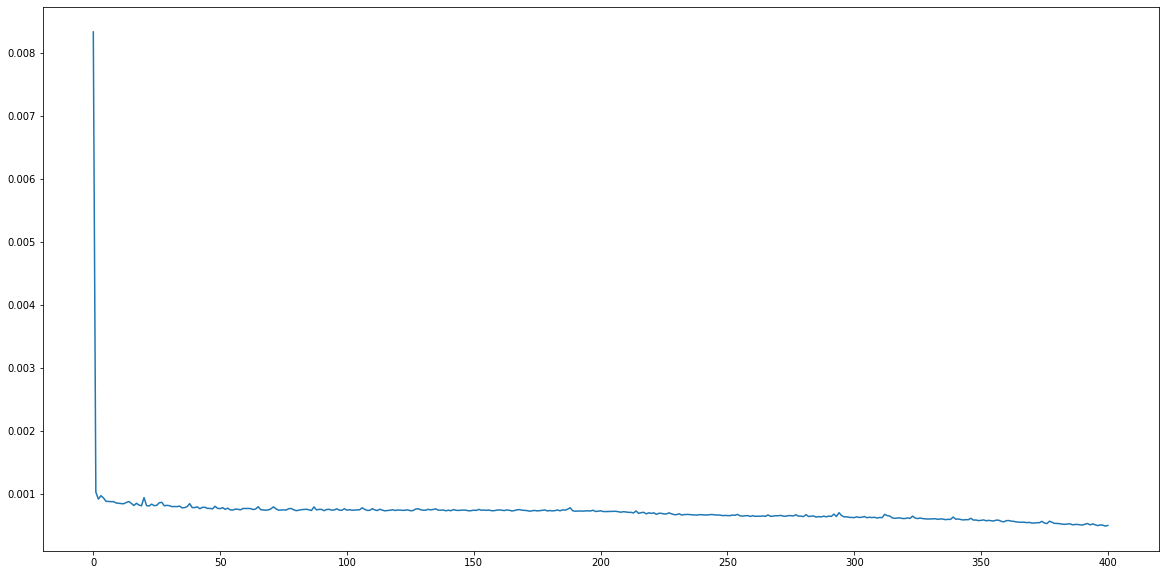

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [ ]:
concat_data = torch.utils.data.ConcatDataset([train_data, test_data])
oneday_data_loader = torch.utils.data.DataLoader(dataset=concat_data, batch_size=100)
continuous_data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=100)

with torch.no_grad():   
   model.eval()
   oneday_pred = []
   for data in oneday_data_loader:
      seq, target = data
      out = model(seq)
      oneday_pred += out.cpu().tolist()

   continuous_pred = []
   for data in continuous_data_loader:
      seq, target = data
      out = model(seq)
      continuous_pred += out.cpu().tolist()
   for _ in range(3684 - split):
      seq = torch.cat([seq[-1][1:], out[-1].unsqueeze(0)], axis=0).unsqueeze(0)
      out = model(seq)
      continuous_pred += out.cpu().tolist()

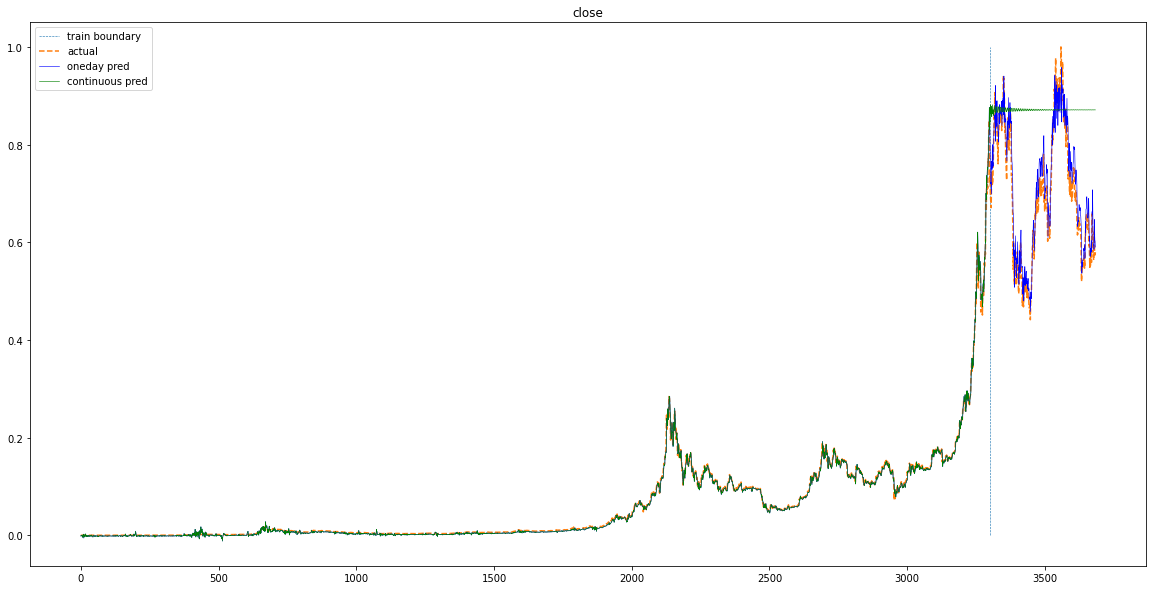

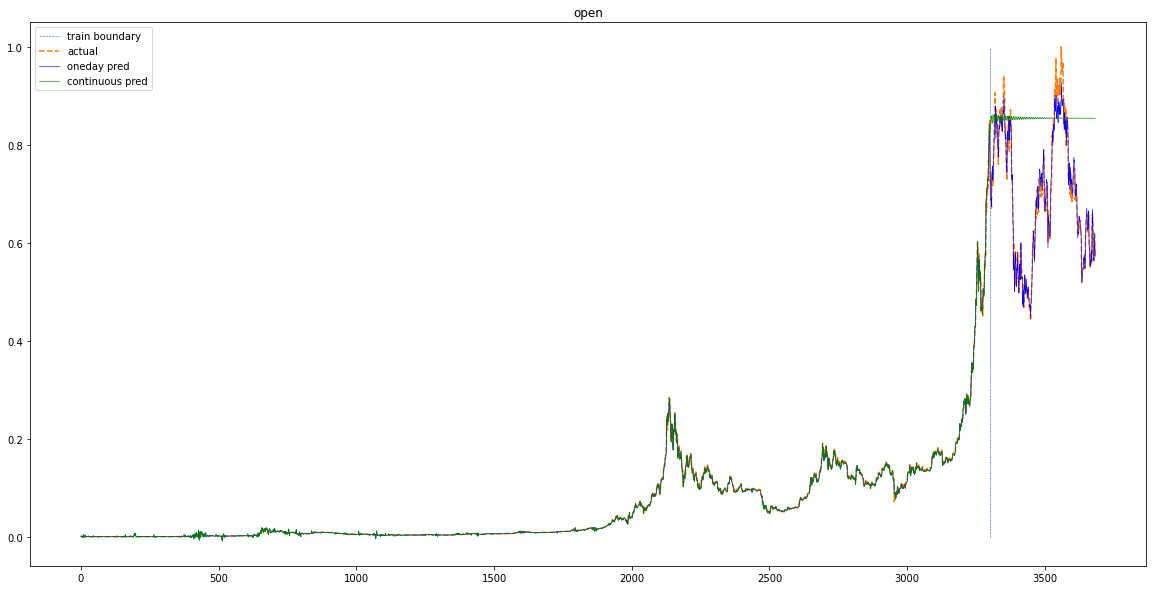

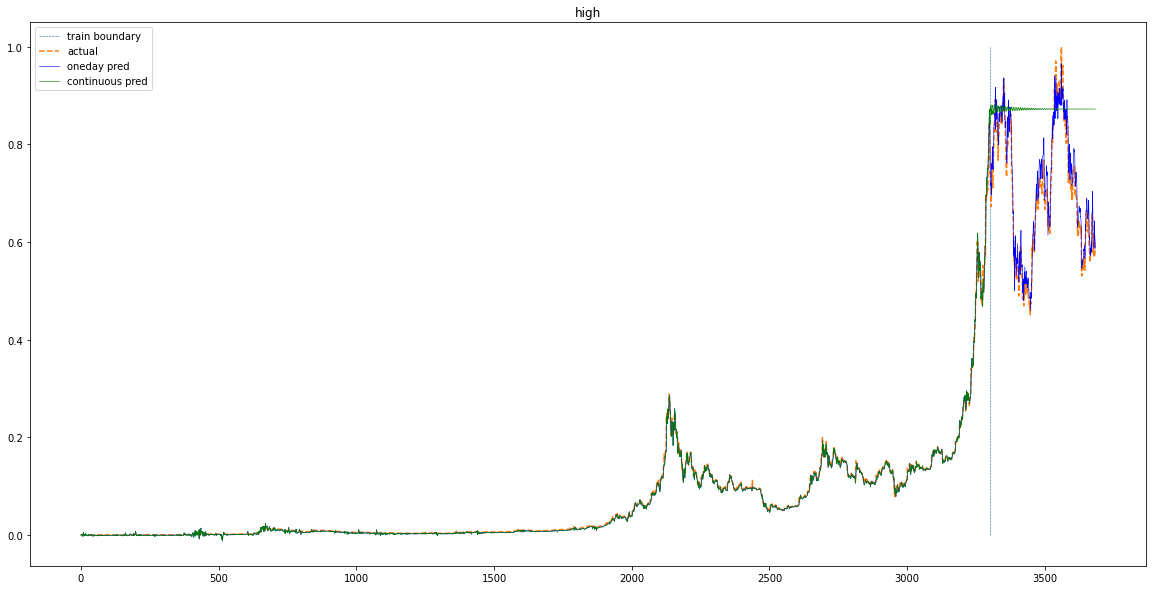

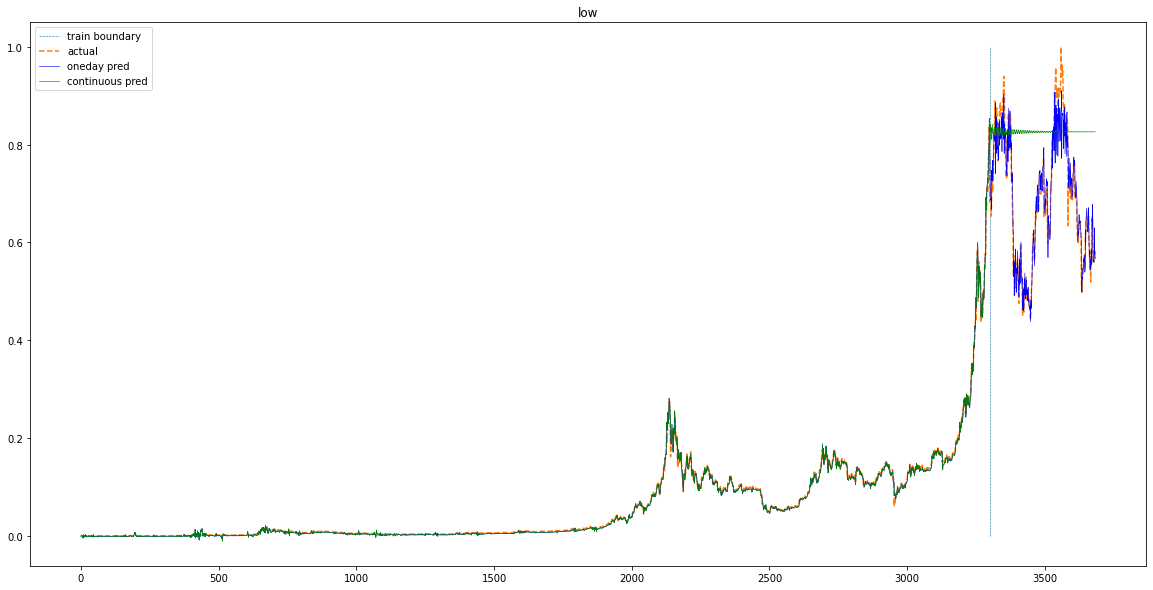

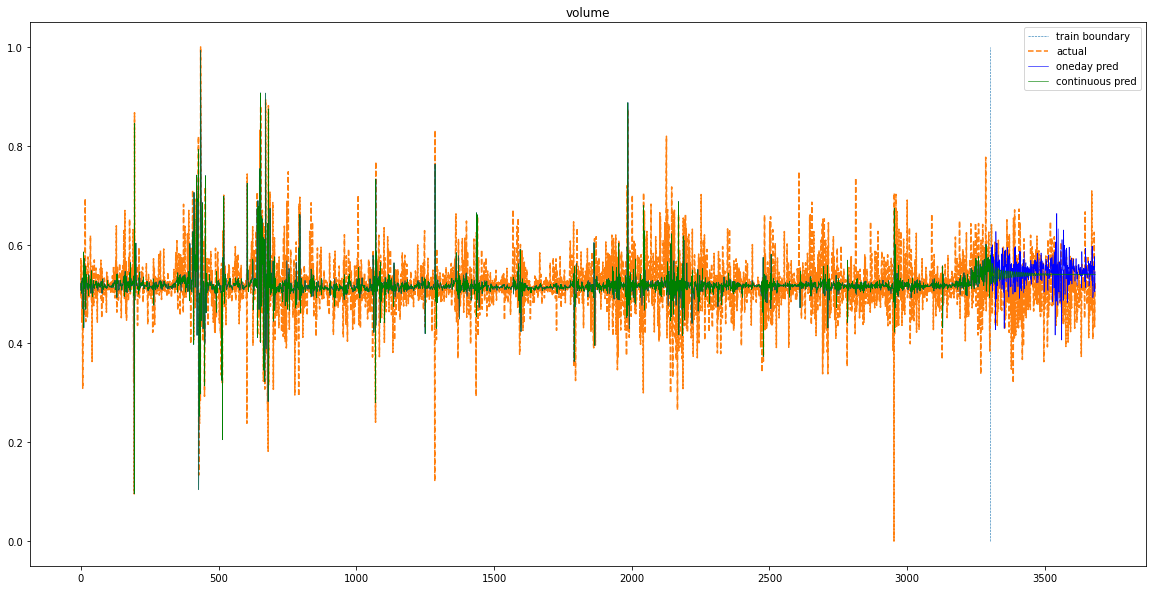

In [ ]:
title = ["close", "open", "high", "low", "volume"]
for idx, col in enumerate(column_names):
   plt.figure(figsize=(20, 10))
   plt.title(title[idx])
   plt.plot(np.ones(100)*len(train_data), np.linspace(0, 1, 100), '--', linewidth=0.6)
   plt.plot(BTC_DATA[col][sequence_length:].values, '--')
   plt.plot(np.array(oneday_pred)[:,idx], 'b', linewidth=0.6)
   plt.plot(np.array(continuous_pred)[:,idx], 'g', linewidth=0.6)
   plt.legend(["train boundary", "actual", "oneday pred", "continuous pred"])
   plt.show()

# Unsupervised Learning

## Generative Adversarial Networl

In [ ]:
from torchvision.datasets import FashionMNIST

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
trainset = FashionMNIST(root="./data/", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}...")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Using cuda...


Linear Version

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.n_features = 128
    self.n_out = 784
    self.linear = nn.Sequential(
        nn.Linear(self.n_features, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.n_out),
        nn.Tanh())
  
  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 1, 28, 28)
    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_in = 784
    self.n_out = 1
    self.linear = nn.Sequential(
        nn.Linear(self.n_in, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, self.n_out),
        nn.Sigmoid())

  def forward(self, x):
    x = x.view(-1, 784)
    x = self.linear(x)
    return x

Convolution Version

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.n_features = 128
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=True), nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, 3, 2, bias=True), nn.ReLU(True),
        nn.ConvTranspose2d(128, 64, 3, 2, bias=True), nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 2, 2, 1, bias=True), nn.Tanh())
  
  def forward(self, x):
    x = x.view(-1, self.n_features, 1, 1)
    x = self.conv(x)
    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 128, 3, 2, 1, bias=True), nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 3, 2, 1, bias=True), nn.LeakyReLU(0.2),
        nn.Conv2d(256, 256, 3, 2, 1, bias=True), nn.LeakyReLU(0.2),
        nn.Conv2d(256, 1, 3, 2, bias=True), nn.Sigmoid())

  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1, 1)
    return x

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss()

In [ ]:
def noise(n, n_features=128):
  data = torch.randn(n, n_features)
  return data.to(device)

def label_ones(size):
  data = torch.ones(size, 1)
  return data.to(device)

def label_zeros(size):
  data = torch.zeros(size, 1)
  return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
  n = real_data.size(0)
  optimizer.zero_grad()
  prediction_real = discriminator(real_data)
  d_loss = criterion(prediction_real, label_ones(n))
  prediction_fake = discriminator(fake_data)
  g_loss = criterion(prediction_fake, label_zeros(n))
  loss = d_loss + g_loss
  loss.backward()
  optimizer.step()
  return loss.item()

def train_generator(optimizer, fake_data):
  n = fake_data.size(0)
  optimizer.zero_grad()
  prediction = discriminator(fake_data)
  loss = criterion(prediction, label_ones(n))
  loss.backward()
  optimizer.step()
  return loss.item()

In [ ]:
test_noise = noise(64)
l = len(trainloader)
for epoch in range(151):
  g_loss = 0.0
  d_loss = 0.0
  for data in trainloader:
    imgs, _ = data
    n = len(imgs)
    fake_data = generator(noise(n)).detach()
    real_data = imgs.to(device)
    d_loss += train_discriminator(d_optim, real_data, fake_data)
    fake_data = generator(noise(n))
    g_loss += train_generator(g_optim, fake_data)

  img = generator(test_noise).detach().cpu()
  img = make_grid(img)
  images.append(img)
  g_losses.append(g_loss/l)
  d_losses.append(d_loss/l)
  if epoch % 10 == 0:
    print(f"Epoch {epoch}: g_loss:{g_loss/l} d_loss:{d_loss/l}")

Epoch 0: g_loss:7.943456185559432 d_loss:0.055685283230101655
Epoch 10: g_loss:4.948457410732905 d_loss:0.19725938915275038
Epoch 20: g_loss:3.50902020017306 d_loss:0.3860239720592896
Epoch 30: g_loss:2.902596804499626 d_loss:0.4761539975802104
Epoch 40: g_loss:2.729328035314878 d_loss:0.5194540014863014
Epoch 50: g_loss:2.6966995127995808 d_loss:0.5193100975950559
Epoch 60: g_loss:2.702931057016055 d_loss:0.5142606012026469


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"
GENERATOR_SAVE_PATH = f"{MODEL_SAVE_PATH}/generator.pt"
DISCRIMINATOR_SAVE_PATH = f"{MODEL_SAVE_PATH}/discriminator.pt"
torch.save(generator.state_dict(), GENERATOR_SAVE_PATH)
torch.save(discriminator.state_dict(), DISCRIMINATOR_SAVE_PATH)

In [ ]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave("fasion_items.gif", imgs)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(["Generator", "Discriminator"])
plt.title("Loss")
plt.savefig("gan_loss.png")

## Image Style Transfer

In [ ]:
STYLE_IMAGE_URL = "https://www.artinsight.co.kr/data/tmp/1912/20191210235617_eostfpur.jpg"
CONTENT_IMAGE_URL = "https://img.insight.co.kr/static/2019/04/10/700/m32ewfrrf7y6b20047xb.jpg"

urllib.request.urlretrieve(STYLE_IMAGE_URL, "/content/style_image.jpg")
urllib.request.urlretrieve(CONTENT_IMAGE_URL, "/content/content_image.jpg")

('/content/content_image.jpg', <http.client.HTTPMessage at 0x7f2d4f6a2b10>)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
def gram_matrix(input):
  a,b,c,d = input.size()
  features = input.view(a*b, c*d)
  G = torch.mm(features, features.t())
  return G.div(a*b*c*d)

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
  
  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = mean.view(-1, 1, 1)
    self.std = std.view(-1, 1, 1)
  
  def forward(self, img):
    return (img - self.mean) / self.std

In [ ]:
def get_style_model_and_losses(cnn, style_img, content_img):
  content_layers = ["conv_4"]
  style_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]
  normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
  normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  content_losses = []
  style_losses = []
  model = nn.Sequential(normalization)
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
      name = f"relu_{i}"
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = f"maxpool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
      name = f"bn_{i}"
    else:
      raise RuntimeError(f"Unrecognized layer : {layer.__class__.__name__}")

    model.add_module(name, layer)
    if name in content_layers:
      target = model(content_img)
      content_loss = ContentLoss(target)
      model.add_module(f"content_loss_{i}", content_loss)
      content_losses.append(content_loss)
    if name in style_layers:
      target_feature = model(style_img)
      style_loss = StyleLoss(target_feature)
      model.add_module(f"style_loss_{i}", style_loss)
      style_losses.append(style_loss)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i+1)]
  return model, style_losses, content_losses  

In [ ]:
def run_style_transfer(cnn, content_img, style_img, num_steps=400, style_weight=100000, content_weight=1):
  input_img = content_img.clone().detach().requires_grad_(True)
  model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
  optimizer = optim.LBFGS([input_img])
  iteration = [0]
  while iteration[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      loss = style_weight*style_score + content_weight*content_score
      loss.backward()
      iteration[0] += 1
      if iteration[0] % 50 == 0:
        print(f"Iteration {iteration[0]}: Style Loss : {style_score.item()} Content Loss : {content_score.item()}")
      return style_score + content_score
    optimizer.step(closure)
  return input_img.data.clamp(0, 1)

In [ ]:
def image_loader(img_path):
  loader = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
  image = Image.open(img_path).convert("RGB")
  image = loader(image).unsqueeze(0)
  return image.to(device)

STYLE_IMAGE_PATH = "/content/style_image.jpg"
CONTENT_IMAGE_PATH = "/content/content_image.jpg"
style_img = image_loader(STYLE_IMAGE_PATH)
content_img = image_loader(CONTENT_IMAGE_PATH)

In [ ]:
output = run_style_transfer(cnn, content_img, style_img, num_steps=300)

Iteration 50: Style Loss : 0.00030348089057952166 Content Loss : 34.99315643310547
Iteration 100: Style Loss : 8.971006900537759e-05 Content Loss : 25.032758712768555
Iteration 150: Style Loss : 3.5414050216786563e-05 Content Loss : 19.65741729736328
Iteration 200: Style Loss : 2.4822778868838213e-05 Content Loss : 16.634628295898438
Iteration 250: Style Loss : 2.206280805694405e-05 Content Loss : 15.236971855163574
Iteration 300: Style Loss : 1.9387214706512168e-05 Content Loss : 14.687284469604492


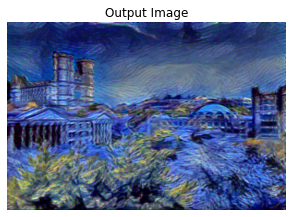

False

In [ ]:
def imshow(image, origin_size, title):
  unloader = transforms.Compose([transforms.Resize(origin_size), transforms.ToPILImage()])
  image = unloader(image.squeeze(0).cpu())
  plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.title(title)
  plt.axis("off")
  plt.show()
origin_image = cv2.imread("/content/content_image.jpg")
imshow(output, origin_image.shape[:2], title="Output Image")

## Deep K-Means Algorithm

In [ ]:
from scipy.optimize import linear_sum_assignment as linear_assignment

In [ ]:
batch_size = 128
num_clusters = 10
latent_size = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
trainset = torchvision.datasets.MNIST("./data/", download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST("./data/", download=True, train=False, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1)

class Deflatten(nn.Module):
  def __init__(self, k):
    super(Deflatten, self).__init__()
    self.k = k
  
  def forward(self, x):
    s = x.size()
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0], self.k, feature_size, feature_size)
  
class Kmeans(nn.Module):
  def __init__(self, num_clusters, latent_size):
    super(Kmeans, self).__init__()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.num_clusters = num_clusters
    self.centroids = nn.Parameter(torch.rand((self.num_clusters, latent_size)).to(device))

  def argminl2distance(self, a, b):
    return torch.argmin(torch.sum((a-b)**2, dim=1), dim=0)

  def forward(self, x):
    y_assign = []
    for m in range(x.size(0)):
      h = x[m].expand(self.num_clusters, -1)
      assign = self.argminl2distance(h, self.centroids)
      y_assign.append(assign.item())
    return y_assign, self.centroids[y_assign]

class Encoder(nn.Module):
  def __init__(self, latent_size):
    super(Encoder, self).__init__()
    k = 16
    self.encoder = nn.Sequential(
        nn.Conv2d(1, k, 3, stride=2), nn.ReLU(),
        nn.Conv2d(k, 2*k, 3, stride=2), nn.ReLU(),
        nn.Conv2d(2*k, 4*k, 3, stride=1), nn.ReLU(),
        Flatten(),
        nn.Linear(1024, latent_size), nn.ReLU())
  
  def forward(self, x):
    return self.encoder(x)

class Decoder(nn.Module):
  def __init__(self, latent_size):
    super(Decoder, self).__init__()
    k = 16
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 1024), nn.ReLU(),
        Deflatten(4*k),
        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), nn.ReLU(),
        nn.ConvTranspose2d(2*k, k, 3, stride=2), nn.ReLU(),
        nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1), nn.Sigmoid())
  
  def forward(self, x):
    return self.decoder(x)

In [ ]:
def cluster_acc(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  D = max(y_pred.max(), y_true.max()) + 1
  w = np.zeros((D, D), dtype=np.int64)
  for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
  ind = linear_assignment(w.max() - w)
  return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size

In [ ]:
def evaluation(testloader, encoder, kmeans, device):
  predictions = []
  actual = []

  with torch.no_grad():
    for images, labels in testloader:
      inputs = images.to(device)
      labels = labels.to(device)
      latent_var = encoder(inputs)
      y_pred, _ = kmeans(latent_var)

      predictions += y_pred
      actual += labels.cpu().tolist()
  
  return cluster_acc(actual, predictions)

In [ ]:
encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters, latent_size).to(device)
criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(kmeans.parameters()), lr=1e-3)

In [ ]:
T1 = 50
T2 = 200
lam = 1e-3
ls = 0.05
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

In [ ]:
for ep in range(300):
  if (ep > T1) and (ep < T2):
    alpha = lam * (ep - T1) / (T2 - T1)
  elif ep >= T2:
    alpha = lam
  else:
    alpha = lam/(T2 - T1)
  
  running_loss = 0.0
  for images, _ in trainloader:
    inputs = images.to(device)
    optimizer.zero_grad()
    latent_var = encoder(inputs)
    _, centroids = kmeans(latent_var.detach())
    outputs = decoder(latent_var)

    l_rec = criterion1(inputs, outputs)
    l_clt = criterion2(latent_var, centroids)
    loss = l_rec + alpha * l_clt
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  
  avg_loss = running_loss / len(trainloader)

  if ep % 10 == 0:
    testacc = evaluation(testloader, encoder, kmeans, device)
    print("[%d] Train loss: %.4f, Test Accuracy: %.3f" % (ep, avg_loss, testacc))

  if avg_loss < ls:
    ls = avg_loss
    torch.save(encoder.state_dict(), f"{MODEL_SAVE_PATH}/dkm_encoder.pt")
    torch.save(decoder.state_dict(), f"{MODEL_SAVE_PATH}/dkm_decoder.pt")
    torch.save(kmeans.state_dict(), f"{MODEL_SAVE_PATH}/dkm_kmeans.pt")

[0] Train loss: 0.0847, Test Accuracy: 0.114
[10] Train loss: 0.0273, Test Accuracy: 0.201
[20] Train loss: 0.0248, Test Accuracy: 0.374
[30] Train loss: 0.0238, Test Accuracy: 0.552
[40] Train loss: 0.0232, Test Accuracy: 0.603
[50] Train loss: 0.0227, Test Accuracy: 0.652
[60] Train loss: 0.0225, Test Accuracy: 0.679


KeyboardInterrupt: ignored

In [ ]:
encoder.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/dkm_encoder.pt"))
decoder.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/dkm_decoder.pt"))
kmeans.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/dkm_kmeans.pt"))

predictions = []
actual = []
latent_features = []
with torch.no_grad():
  for images, labels in testloader:
    inputs = images.to(device)
    labels = labels.to(device)
    latent_var = encoder(inputs)
    y_pred, _ = kmeans(latent_var)

    predictions += y_pred
    latent_features += latent_var.cpu().tolist()
    actual += labels.cpu().tolist()
print(cluster_acc(actual, predictions))

0.6864


# Performance Improvement Technique

## Prevent Overfitting

1. Data Augmentation

2. L2 Regularization

3. Dropout

4. Batch Normalization

5. Disturb Label (used when classfication task)

In [ ]:
class DisturbLabel(nn.Module):
  def __init__(self, alpha, num_classes):
    super(DisturbLabel, self).__init__()
    self.alpha = alpha
    self.C = num_classes
    self.p_c = (1 - ((self.C - 1) / self.C) * (alpha / 100))
    self.p_i = (1 - self.p_c) / (self.C - 1)

  def forward(self, y):
    y_tensor = y.type(torch.LongTensor).view(-1, 1)
    depth = self.C
    y_one_hot = torch.ones(y_tensor.size()[0], depth) * self.p_i
    y_one_hot.scatter_(1, y_tensor, self.p_c)
    y_one_hot = y_one_hot.view(*(tuple(y.shape) + (-1,)))
    distribution = torch.distributions.OneHotCategorical(y_one_hot)
    y_disturbed = distribution.sample()
    y_disturbed = y_disturbed.max(dim=1)[1]
    return y_disturbed

In [ ]:
disturblabels = DisturbLabel(alpha=30, num_classes=10)

In [ ]:
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    labels = disturblabels(labels).to(device)
    loss = criterion(outputs, labels)
    # ...... 이하 생략 ......

6. Disturb Value (used when regression task)

In [ ]:
def noise_generator(x, alpha):
  noise = torch.normal(0, 1e-8, size=(len(x), 1))
  noise[torch.randint(0, len(x), (int(len(x) * (1 - alpha)),))] = 0
  return noise

In [ ]:
for epoch in range(400):
  for data in trainloader:
    inputs, values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    values = values + noise_generator(values, alpha)
    loss =criterion(outputs, values)
    # ...... 이하 생략 ......

7. Label Smoothing

\begin{align}
  y_{ls} = (1 - α)y\hspace{0.2cm}+\hspace{0.2cm} \frac{α}{K}
  \\(K는 클래스 수, α는 스무딩 비율, y는 0 또는 1)
\end{align}

In [ ]:
class LabelSmoothingLoss(nn.Module):
  def __init__(self, classes, smoothing=0.0, dim=-1):
    super(LabelSmoothingLoss, self).__init__()
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.cls = classes
    self.dim = dim
  
  def forward(self, pred, target):
    pred = pred.log_softmax(dim=self.dim)
    with torch.no_grad():
      true_dist = torch.zeros_like(pred)
      true_dist.fill_(self.smoothing / (self.cls - 1))
      true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
    return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
criterion = LabelSmoothingLoss(classes=10, smoothing=0.2)

## Resolved Data Imvalanced

design for dataloader

In [ ]:
def make_weights(labels, nclasses):
  labels = np.array(labels)
  weight_list = []
  for cls in range(nclasses):
    idx = np.where(labels == cls)[0]
    count = len(idx)
    weight = 1 / count
    weights = [weight] * count
    weight_list += weights
  return weight_list

In [ ]:
transf = transforms.Compose([transforms.Resize((16, 16)), transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True,  transform=transf)

weights = make_weights(trainset.targets, len(trainset.classes))
weights = torch.DoubleTensor(weights)

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
trainloader_wrs = DataLoader(trainset, batch_size=6, sampler=sampler)
trainloader_rs = DataLoader(trainset, batch_size=6, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
for idx, data in enumerate(trainloader_wrs):
  print(data[1])
  if idx == 5: break
print("="*15)
for idx, data in enumerate(trainloader_rs):
  print(data[1])
  if idx == 5: break

# 뭐 대충 비율 알맞게 나온다고 한다.

tensor([5, 0, 4, 3, 3, 4])
tensor([5, 2, 9, 4, 4, 2])
tensor([2, 6, 4, 6, 7, 3])
tensor([5, 1, 7, 3, 2, 5])
tensor([6, 8, 6, 3, 5, 1])
tensor([4, 8, 6, 6, 2, 0])
tensor([1, 1, 9, 3, 2, 5])
tensor([4, 2, 1, 4, 3, 3])
tensor([1, 7, 4, 7, 9, 2])
tensor([0, 2, 8, 1, 1, 4])
tensor([6, 1, 2, 3, 1, 8])
tensor([5, 0, 5, 4, 6, 3])


function of nn.CrossEntropyLoss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
num_ins = [40, 35, 20, 65, 70, 153, 408, 43, 58, 183, 590] # lenght of each classes
weights = [(1 - (x / sum(num_ins)) for x in num_ins)]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

Confusion Matrix : for result analysis, not for directly resolved data imblance problem

대각 성분이 짙으면 예측을 잘한거다.

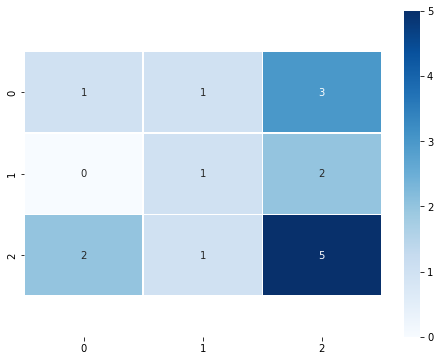

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

actual = [1,1,1,0,0,0,0,0,2,2,2,2,2,2,2,2]
prediction = [1,2,2,0,2,2,1,2,0,1,0,2,2,2,2,2]
c_mat = confusion_matrix(actual, prediction)
plt.figure(figsize = (8, 6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap="Blues", linewidths=.5)
b, t = plt.ylim()
b += .5
t -= .5
plt.ylim(b, t)
plt.savefig("/content/confusion_matrix.png")
plt.show()
# 예측값이 2에 많이 치우친 것을 알 수 있다. 
# 이를 통해서 2가 상대적으로 과적합 되었다는 해석을 추가적으로 할 수 있다.

## Transfer Learning

Pre-trained Models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = models.alexnet().to(device)
resnet18 = models.resnet18().to(device)
vgg16 = models.vgg16().to(device)
densenet = models.densenet161().to(device)
inception = models.inception_v3().to(device)
googlenet = models.googlenet().to(device)
shufflenet = models.shufflenet_v2_x1_0().to(device)
mobilenet_v2 = models.mobilenet_v2().to(device)
resnext50_32x4d = models.resnext50_32x4d().to(device)
wide_resnet50_2 = models.wide_resnet50_2().to(device)
mnasnet = models.mnasnet1_0().to(device)

In [ ]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
num_ftrs = model.fc.in_features
model.fx = nn.Linear(num_ftrs, 10)
model = model.to(device)

Model Freezing

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# freezing parameters
for i, (name, param) in enumerate(model.named_parameters()):
  param.requires_grad = False
  if i == 9:
    print("end!")
    break

end!


In [ ]:
# check freezing
f_list = [0, 3, 6, 8, 10]
c_list = [1, 4, 6]

for i in f_list:
  print(i, name, model.features[i].weight.requires_grad)
  print(i, name, model.features[i].bias.requires_grad)

for i in c_list:
  print(i, name, model.classifier[i].weight.requires_grad)
  print(i, name, model.classifier[i].bias.requires_grad)

0 classifier.6.bias False
0 classifier.6.bias False
3 classifier.6.bias False
3 classifier.6.bias False
6 classifier.6.bias False
6 classifier.6.bias False
8 classifier.6.bias False
8 classifier.6.bias False
10 classifier.6.bias False
10 classifier.6.bias False
1 classifier.6.bias True
1 classifier.6.bias True
4 classifier.6.bias True
4 classifier.6.bias True
6 classifier.6.bias True
6 classifier.6.bias True


## Semi-supervised Learning

Pseudo Labeling

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MyDataset(Dataset):
  def __init__(self, x_data, y_data, transform=None):
    self.x_data = x_data
    self.y_data = y_data
    self.transform = transform
    self.len = len(y_data)

  def __getitem__(self, index):
    sample = self.x_data[index], self.y_data[index]
    if self.transform:
      sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.len

class TrainTransform:
  def __call__(self, sample):
    inputs, labels = sample
    transf = transforms.Compose([
                                 transforms.ToPILImage(), 
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor()])
    final_output = transf(inputs)
    return final_output, labels

In [ ]:
def balanced_subset(data, labels, num_cls, num_data):
  num_data_per_class = num_data // num_cls
  data1 = torch.tensor([], dtype=torch.float)
  data2 = torch.tensor([], dtype=torch.float)
  labels1 = torch.tensor([], dtype=torch.long)
  labels2 = torch.tensor([], dtype=torch.long)
  for cls in range(num_cls):
    idx = np.where(labels.numpy() == cls)[0]
    shuffled_idx = np.random.choice(len(idx), len(idx), replace=False)
    data1 = torch.cat([data1, data[shuffled_idx[:num_data_per_class]]], dim=0)
    data2 = torch.cat([data2, data[shuffled_idx[num_data_per_class:]]], dim=0)
    labels1 = torch.cat([labels1, labels[shuffled_idx[:num_data_per_class]]], dim=0)
    labels2 = torch.cat([labels2, labels[shuffled_idx[num_data_per_class:]]], dim=0)
  return data1, data2, labels1, labels2

In [ ]:
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True)
labeled_data, unlabeled_data, labels, unlabels = balanced_subset(trainset.data, trainset.targets, num_cls=10, num_data=2000)
train_images, val_images, train_labels, val_labels = balanced_subset(labeled_data, labels, num_cls=10, num_data=1000)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_images = train_images.unsqueeze(1)
val_images = val_images.unsqueeze(1)
trainset = MyDataset(train_images, train_labels, transform=TrainTransform())
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
validationset = MyDataset(val_images, val_labels)
valloader = DataLoader(validationset, batch_size=128, shuffle=False)
unlabeled_images = unlabeled_data.unsqueeze(1)
unlabeledset = MyDataset(unlabeled_images, unlabels)
unlabeledloader = DataLoader(unlabeledset, batch_size=256, shuffle=True)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 64, 3), nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2, 2))
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(192*6*6, 1024), nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512), nn.ReLU(),
        nn.Linear(512, 10))
  
  def forward(self, x):
    x = self.features(x)
    x = x.view(-1, 192*6*6)
    x = self.classifier(x)
    return x

In [ ]:
def accuracy(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  acc = 100 * correct / total
  model.train()
  return acc

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

Supervised Learning Model for Pseudo Labaling Model Baseline

In [ ]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
best_acc = 0
for epoch in range(501):
  correct = 0
  total = 0
  for traindata in trainloader:
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  val_acc = accuracy(valloader)
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_baseline.pt")
    print("[%d] train acc: %.2f, validation acc: %.2f - Saved the best model" %(epoch, 100*correct / total, val_acc))
  elif epoch % 10 == 0:
    print("[%d] train acc: %.2f, validation acc: %.2f" %(epoch, 100*correct / total, val_acc))

[0] train acc: 18.50, validation acc: 23.40 - Saved the best model
[1] train acc: 40.00, validation acc: 43.80 - Saved the best model
[2] train acc: 48.80, validation acc: 55.20 - Saved the best model
[10] train acc: 94.20, validation acc: 50.00
[11] train acc: 95.40, validation acc: 56.00 - Saved the best model
[12] train acc: 95.90, validation acc: 59.50 - Saved the best model
[20] train acc: 99.20, validation acc: 59.80 - Saved the best model
[27] train acc: 99.50, validation acc: 60.70 - Saved the best model
[29] train acc: 99.70, validation acc: 61.30 - Saved the best model
[30] train acc: 99.80, validation acc: 56.70
[32] train acc: 99.90, validation acc: 62.20 - Saved the best model
[40] train acc: 99.80, validation acc: 53.90
[41] train acc: 99.80, validation acc: 67.60 - Saved the best model
[50] train acc: 98.90, validation acc: 66.20
[53] train acc: 99.70, validation acc: 67.90 - Saved the best model
[57] train acc: 99.80, validation acc: 72.60 - Saved the best model
[60] tr

In [ ]:
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_baseline.pt"))
accuracy(testloader)

78.95

Semi-supervised Learning Model 1

모델이 일정 수준 학습되면 라벨링이 안된 데이터 또한 예측시키고 나온 예측값과 예측값을 max를 취한 값으로 cost를 계산하여 학습하는 방법.

In [ ]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
alpha = 0
alpha_t = 1e-4
T1 = 100
T2 = 450
best_acc = 0

In [ ]:
for epoch in range(501):
  correct = 0
  total = 0
  for traindata, pseudodata in zip(trainloader, unlabeledloader):
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    pinputs = pseudodata[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    if alpha > 0:
      poutputs = model(pinputs)
      _, plabels = torch.max(poutputs.detach(), 1)
      loss = criterion(outputs, labels) + alpha * criterion(poutputs, plabels)
    else:
      loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
  if (epoch > T1) and (epoch < T2):
    alpha = alpha_t * (epoch - T1) / (T2 - T1)
  elif epoch >= T2:
    alpha = alpha_t
  
  val_acc = accuracy(valloader)
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_label1.pt")
    print("[%d] train acc: %.2f, validation acc: %.2f - Saved the best model" %(epoch, 100*correct / total, val_acc))
  elif epoch % 10 == 0:
    print("[%d] train acc: %.2f, validation acc: %.2f" %(epoch, 100*correct / total, val_acc))

[0] train acc: 15.50, validation acc: 26.30 - Saved the best model
[1] train acc: 38.90, validation acc: 40.20 - Saved the best model
[2] train acc: 48.80, validation acc: 41.60 - Saved the best model
[4] train acc: 66.40, validation acc: 55.30 - Saved the best model
[7] train acc: 84.90, validation acc: 60.50 - Saved the best model
[8] train acc: 89.00, validation acc: 62.30 - Saved the best model
[9] train acc: 92.10, validation acc: 66.30 - Saved the best model
[10] train acc: 92.80, validation acc: 65.40
[12] train acc: 95.00, validation acc: 68.00 - Saved the best model
[15] train acc: 98.90, validation acc: 70.80 - Saved the best model
[16] train acc: 98.70, validation acc: 70.80 - Saved the best model
[19] train acc: 99.20, validation acc: 74.10 - Saved the best model
[20] train acc: 99.50, validation acc: 73.60
[21] train acc: 99.90, validation acc: 74.30 - Saved the best model
[22] train acc: 99.10, validation acc: 81.30 - Saved the best model
[30] train acc: 99.70, validation

In [ ]:
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_label1.pt"))
accuracy(testloader)

79.08

Semi-supervised Learning Model 2

라벨링이 된 데이터로 지도 학습된 모델을 이용하여 의사 라벨을 만들어 학습하는 방법

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_baseline.pt"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
pseudo_threshold = 0.99
pseudo_images = torch.tensor([], dtype=torch.float)
pseudo_labels = torch.tensor([], dtype=torch.long)
with torch.no_grad():
  for data in tqdm(unlabeledloader):
    model.eval()
    images = data[0].to(device)
    outputs = model(images)
    outputs = F.softmax(outputs, dim=1)
    max_val, predicted = torch.max(outputs.detach(), 1)
    idx = np.where(max_val.cpu().numpy() >= pseudo_threshold)[0]
    if len(idx) > 0:
      pseudo_images = torch.cat((pseudo_images, images.cpu()[idx]), 0)
      pseudo_labels = torch.cat((pseudo_labels, predicted.cpu()[idx]), 0)

100%|██████████| 227/227 [00:07<00:00, 32.04it/s]


In [ ]:
pseudo_dataset = MyDataset(pseudo_images, pseudo_labels)
pseudoloader = DataLoader(pseudo_dataset, batch_size=256, shuffle=True)

In [ ]:
alpha = 0
alpha_t = 1e-4
T1 = 100
T2 = 450
best_acc = 0

In [ ]:
for epoch in range(501):
  correct = 0
  total = 0
  for traindata, pseudodata in zip(trainloader, pseudoloader):
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    pinputs, plabels = pseudodata[0].to(device), pseudodata[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    poutputs = model(pinputs)
    loss = criterion(outputs, labels) + alpha * criterion(poutputs, plabels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
  if (epoch > T1) and (epoch < T2):
    alpha = alpha_t * (epoch - T1) / (T2 - T1)
  elif epoch >= T2:
    alpha = alpha_t
  
  val_acc = accuracy(valloader)
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_label2.pt")
    print("[%d] train acc: %.2f, validation acc: %.2f - Saved the best model" %(epoch, 100*correct / total, val_acc))
  elif epoch % 10 == 0:
    print("[%d] train acc: %.2f, validation acc: %.2f" %(epoch, 100*correct / total, val_acc))

[0] train acc: 100.00, validation acc: 57.90 - Saved the best model
[1] train acc: 99.70, validation acc: 76.50 - Saved the best model
[10] train acc: 99.90, validation acc: 65.30
[13] train acc: 99.80, validation acc: 82.00 - Saved the best model
[20] train acc: 99.30, validation acc: 80.10
[30] train acc: 99.90, validation acc: 74.50
[35] train acc: 99.80, validation acc: 83.80 - Saved the best model
[36] train acc: 100.00, validation acc: 84.30 - Saved the best model
[40] train acc: 100.00, validation acc: 77.90
[50] train acc: 99.50, validation acc: 74.70
[60] train acc: 99.90, validation acc: 80.20
[70] train acc: 99.60, validation acc: 75.60
[80] train acc: 100.00, validation acc: 67.60
[90] train acc: 100.00, validation acc: 71.50
[100] train acc: 100.00, validation acc: 78.40
[103] train acc: 100.00, validation acc: 84.50 - Saved the best model
[104] train acc: 100.00, validation acc: 88.80 - Saved the best model
[110] train acc: 100.00, validation acc: 86.50
[120] train acc: 1

In [ ]:
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_model_for_pseudo_label2.pt"))
accuracy(testloader)

75.4

결과적으로 1번 준지도 학습 방법이 성능을 향상시켰다. 2번 준지도 학습의 경우 부정확한 라벨링으로 때문에 성능 저하가 발생한듯 하다.

# Visualization

## Explainable AI, XAI

Class Activation Map

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

In [ ]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root="./data", split="train", download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=40, shuffle=True)
testset = torchvision.datasets.STL10(root="./data", split="test", download=True, transform=transform)
testloader = DataLoader(testset, batch_size=40, shuffle=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/stl10_resnet18.pt"))

<All keys matched successfully>

In [ ]:
def acc(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print("Accuracy: %d %%" % (100 * correct / total))
acc(trainloader)
acc(testloader)

Accuracy: 99 %
Accuracy: 82 %


In [ ]:
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [ ]:
def cam(dataset, img_sample, img_size):
  model.eval()
  with torch.no_grad():
    model.layer4[1].bn2.register_forward_hook(get_activation("final"))
    data, label = dataset[img_sample]
    data.unsqueeze_(0)
    output = model(data.to(device))
    _, prediction =torch.max(output, 1)
    act = activation["final"].squeeze()
    w = model.fc.weight
    for idx in range(act.size(0)):
      if idx == 0:
        tmp = act[idx] * w[prediction.item()][idx]
      else:
        tmp += act[idx] * w[prediction.item()][idx]
    normalized_cam = tmp.cpu().numpy()
    normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
    original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)
    cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size))
  return cam_img, original_img, prediction, label

In [ ]:
def plot_cam(dataset, img_size, start):
  end = start + 20
  fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize = (20, 4))
  fig.subplots_adjust(hspace=.01, wspace=.01)
  axs = axs.ravel()
  cls = ["airplabe", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
  for i in range(start, end):
    cam_img, original_img, prediction, label = cam(dataset, i, img_size)
    if prediction == label:
      color = "white"
    else:
      color = "red"
    axs[i - start].imshow(original_img, cmap="gray")
    axs[i - start].imshow(cam_img, cmap="jet", alpha=.4)
    axs[i - start].text(5, 5, cls[prediction], bbox={"facecolor":color, "pad":5})
    axs[i - start].axis("off")
  plt.show()

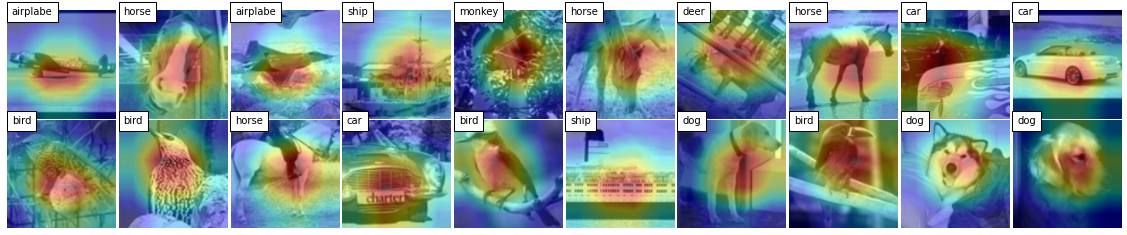

In [ ]:
plot_cam(trainset, 128, 10)

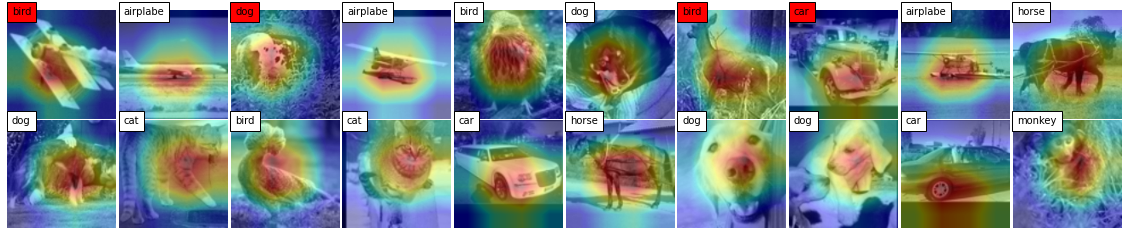

In [ ]:
plot_cam(testset, 128, 10)

## Dimension Reduction Techniques

t-SNE : t-distributed Stochastic Neighbor Embedding

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=6)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  def forward(self, x):
    return x
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar10_resnet18.pt"))
model.fc = Identity()

In [ ]:
actual = []
deep_features = []
model.eval()
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    features = model(images)
    deep_features += features.cpu().tolist()
    actual += labels.cpu().tolist()

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)
print(cluster.shape)
print(actual.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


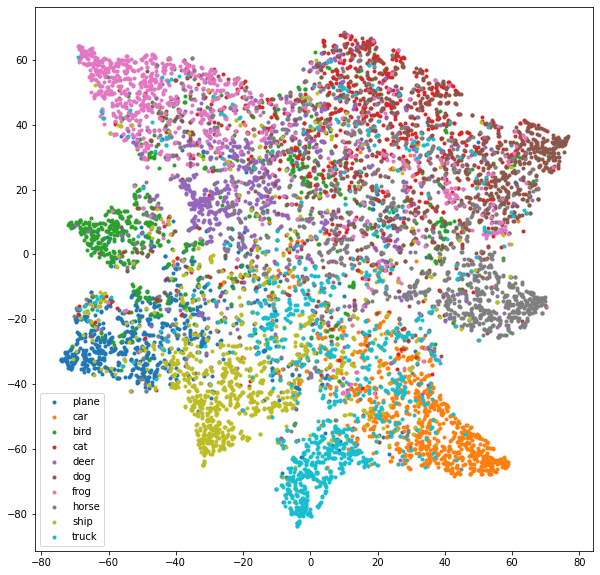

In [ ]:
plt.figure(figsize=(10, 10))
cifar = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i, label in zip(range(10), cifar):
  idx = np.where(actual == i)
  plt.scatter(cluster[idx, 0], cluster[idx, 1], marker=".", label=label)
plt.legend()
plt.show()

PCA : Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cluster = np.array(pca.fit_transform(np.array(deep_features)))
print(pca.explained_variance_ratio_)
print(cluster.shape)

[0.21694763 0.17314635]


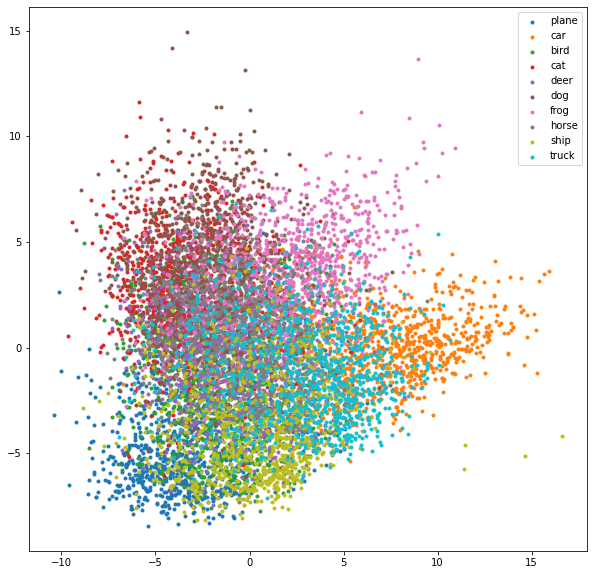

In [ ]:
plt.figure(figsize=(10, 10))
cifar = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i, label in zip(range(10), cifar):
  idx = np.where(actual == i)
  plt.scatter(cluster[idx, 0], cluster[idx, 1], marker=".", label=label)
plt.legend()
plt.show()

# Meta Learning

## Meta Learning and Few-shot Learning

### Meta Learning
- 메타 데이터라고 불리는 방대한 데이터를 이용해 학습하는 방법을 학습하여 적은 데이터로도 새로운 문제를 빠르게 풀 수 있게 하는 방법론

### Few-shot Learning
- 적은 양의 데이터를 가진 여러 가지 업무 세트가 존재할 때 그 업무 세트를 사지고 학습하는 방법을 학습하여 새로운 업무에 대해서 적은 양의 데이터라도 빠르게 학습할 수 있는 메타 학습 방법 중 하나

### MAML : Model-Agnostic Meta-Learning
- 최적화 기반 메타 학습(Optimization-based Meta-Learning) 중 하나로 메타 훈련 데이터를 통해 어떤 식으로 모델을 최적화해야 일반적인 모델 파라미터를 얻을 수 있는지를 학습하는 방법

## MAML regression

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = x_data
    self.y_data = y_data
    self.len = self.y_data.shape[0]
  
  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]
  
  def __len__(self):
    return self.len

class SinusoidalFunction:
  def __init__(self, x_range=5, k=5, num_tasks=4):
    self.x_range = x_range
    self.pi = torch.acos(torch.zeros(1)).item() * 2
    self.k = k
    self.num_tasks = num_tasks

  def meta_train_data(self):
    x_points = 2 * self.x_range * (torch.rand((self.num_tasks, 2 * self.k)) - 0.5)
    y_points = torch.tensor([], dtype=torch.float)
    for x in x_points:
      a = 4 * (torch.rand(1) + 0.1)
      b = self.pi * torch.rand(1)
      y = a * torch.sin(x.view(1, -1)+ b)
      y_points = torch.cat((y_points, y), 0)
    taskset = TensorData(x_points, y_points)
    trainloader = DataLoader(taskset, batch_size=1)
    return trainloader

  def meta_eval_data(self, k):
    x_points = 2 * self.x_range * (torch.rand(2 * k) - 0.5)
    a = 4 * (torch.rand(1) + 0.1)
    b = self.pi * torch.rand(1)
    y_points = a * torch.sin(x_points+ b)
    sup_x = x_points[:k]
    sup_y = y_points[:k]
    que_x = x_points[k:]
    que_y = y_points[k:]
    x = torch.linspace(-self.x_range, self.x_range, 200)
    y = a * torch.sin(x + b)
    return sup_x, sup_y, que_x, que_y, x, y

In [ ]:
k = 5
num_tasks = 2000
sine = SinusoidalFunction(k=k, num_tasks=num_tasks)
trainloader = sine.meta_train_data()

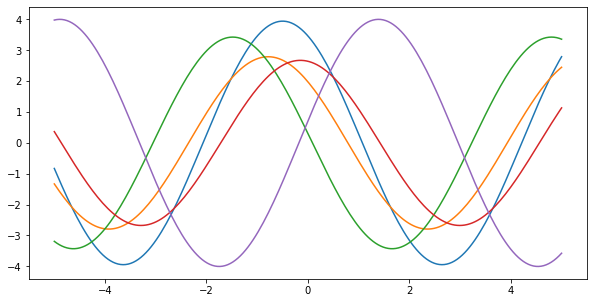

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(5):
  _, _, _, _, x, y = sine.meta_eval_data(5)
  plt.plot(x, y)
plt.show()
plt.close()

In [ ]:
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1, 40)
    self.fc2 = nn.Linear(40, 40)
    self.fc3 = nn.Linear(40, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

  def parameterised(self, x, weights):
    x = F.relu(F.linear(x, weights[0], weights[1]))
    x = F.relu(F.linear(x, weights[2], weights[3]))
    x = F.linear(x, weights[4], weights[5])
    return x

class MAML:
  def __init__(self, trainloader, k, alpha=1e-2, beta=1e-3):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.k = k
    self.model = Regressor().to(device)
    self.weights = list(self.model.parameters())
    self.trainloader = trainloader
    self.beta = beta
    self.criterion = nn.MSELoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
  
  def inner_loop(self, data):
    temp_weights = [w.clone() for w in self.weights]
    inputs, values = data[0].to(device), data[1].to(device)
    support_x = inputs[:, :self.k].T
    support_y = values[:, :self.k].T
    query_x = inputs[:, self.k:].T
    query_y = values[:, self.k:].T

    outputs = self.model.parameterised(support_x, temp_weights)
    loss = self.criterion(outputs, support_y)
    grad = torch.autograd.grad(loss, temp_weights)
    tmp = [w - self.beta * g for w, g in zip(temp_weights, grad)]
    outputs = self.model.parameterised(query_x, tmp)
    inner_loss = self.criterion(outputs, query_y)
    return inner_loss

  def meta_train(self, num_epochs):
    n = len(self.trainloader)
    loss_list = []
    for epoch in range(num_epochs):
      self.optimizer.zero_grad()
      outer_loss = 0

      for data in self.trainloader:
        outer_loss += self.inner_loop(data)

      avg_loss = outer_loss / n
      avg_loss.backward()
      self.optimizer.step()
      ll = avg_loss.item()
      loss_list.append(ll)
      if epoch % 10 == 0:
        print(epoch, ll)

    return loss_list

In [ ]:
maml = MAML(trainloader, k=k)
loss = maml.meta_train(201)

0 3.5039281845092773
10 3.0522537231445312
20 2.9045772552490234
30 2.7688496112823486
40 2.6424365043640137
50 2.5388615131378174
60 2.469054937362671
70 2.4234564304351807
80 2.3804056644439697
90 2.3560030460357666
100 2.3406877517700195
110 2.325392007827759
120 2.3060171604156494
130 2.2906415462493896
140 2.2742013931274414
150 2.2525634765625
160 2.225719451904297
170 2.188523530960083
180 2.0982563495635986
190 2.0096282958984375
200 1.904884934425354


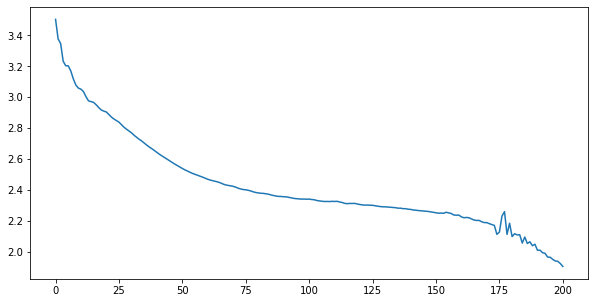

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.show()

In [ ]:
def inference(sup_x, sup_y, x, y, model):
  with torch.no_grad():
    pred = model(x.view(-1, 1).to(device))
    plt.figure(figsize=(10, 5))
    plt.plot(x.cpu().detach(), pred.cpu().detach(), "-b")
    plt.plot(sup_x.cpu().detach(), sup_y.cpu().detach(), ".g")
    plt.plot(x, y, "--r")
    plt.legend(["prediction", "actual points", "actual graph"])
    plt.show()
    plt.close()

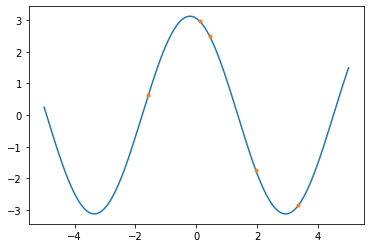

In [ ]:
sup_x, sup_y, _, _, x, y = sine.meta_eval_data(5)
plt.plot(x, y)
plt.plot(sup_x, sup_y, ".")
plt.show()

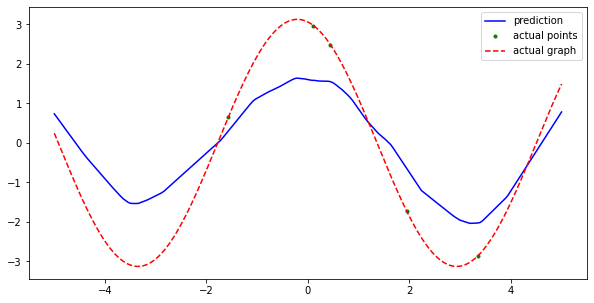

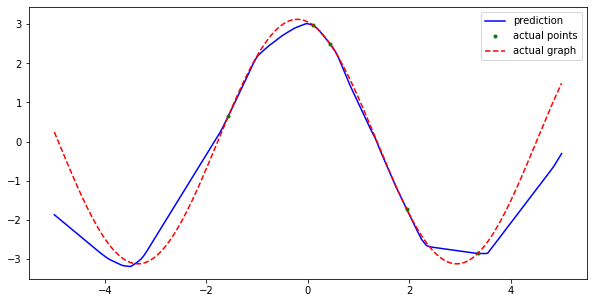

In [ ]:
pre = maml.model
criterion = nn.MSELoss()
optimizer = optim.Adam(pre.parameters(), lr=1e-3)
num_epochs = 501
for i in range(num_epochs):
  optimizer.zero_grad()
  outputs = pre(sup_x.view(-1, 1).to(device))
  loss = criterion(outputs, sup_y.view(-1, 1).to(device))
  loss.backward()
  optimizer.step()
  if i == 0:
    inference(sup_x, sup_y, x, y, pre)
  elif i == num_epochs - 1:
    inference(sup_x, sup_y, x, y, pre)

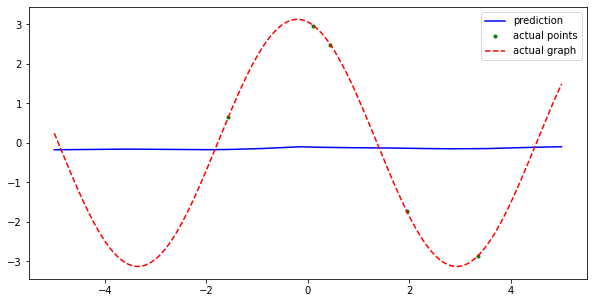

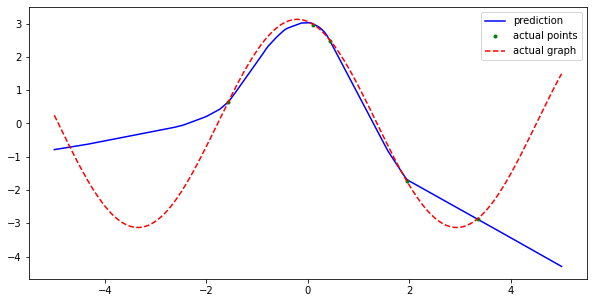

In [ ]:
net = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

for i in range(num_epochs):
  optimizer.zero_grad()
  outputs = net(sup_x.view(-1, 1).to(device))
  loss = criterion(outputs, sup_y.view(-1, 1).to(device))
  loss.backward()
  optimizer.step()
  if i == 0:
    inference(sup_x, sup_y, x, y, net)
  elif i == num_epochs - 1:
    inference(sup_x, sup_y, x, y, net)

## MAML Classification

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MyTransform:
  def __call__(self, sample, mode):
    inputs1, inputs2, labels = sample
    if mode == "train":
      transf = tr.RandomHorizontalFlip()
      output1 = transf(inputs1)  
    else:
      output1 = inputs1
    return output1, inputs2, labels

class TensorData(Dataset):
  def __init__(self, support_set, query_set, labels, mode="train"):
    self.support_set = torch.FloatTensor(support_set).permute(0, 3, 1, 2)
    self.query_set = torch.FloatTensor(query_set).permute(0, 3, 1, 2)
    self.labels = torch.LongTensor(labels)
    self.len = self.labels.shape[0]
    self.transform = MyTransform()
    self.mode = mode

  def __getitem__(self, index):
    sample = self.support_set[index], self.query_set[index], self.labels[index]
    sample = self.transform(sample, self.mode)
    return sample
  
  def __len__(self):
    return self.len

class CIFAR100DataSet:
  def __init__(self, Nway=5, fewshot=5):
    self.cifar = torchvision.datasets.CIFAR100(root="./data", train=True, download=True)
    self.Nway = Nway
    self.fewshot = fewshot
  
  def task_generator(self, cls, mode="train"):
    labels = np.array(self.cifar.targets)
    data = self.cifar.data / 255
    support_set = []
    query_set = []
    targets = []

    for i, c in enumerate(cls):
      idx = np.where(labels == c)[0]
      rand = np.random.choice(len(idx), 2*self.fewshot, replace=False)
      for shot in range(2*self.fewshot):
        img = data[idx[rand[shot]]]

        if shot < self.fewshot:
          support_set.append(img)
          targets.append(i)

        else:
          query_set.append(img)
    
    support_set = np.stack(support_set)
    query_set = np.stack(query_set)
    targets = np.array(targets)
    taskset = TensorData(support_set, query_set, targets, mode=mode)
    dataloader = DataLoader(taskset, batch_size=self.Nway*self.fewshot, shuffle=False)
    return dataloader
  
  def task_set(self, num_tasks, cls, mode="train"):
    task_collection = []
    for i in range(num_tasks):
      task_collection.append(self.task_generator(cls, mode=mode))
    return task_collection

In [ ]:
Nway = 5
fewshot = 5

In [ ]:
cifar100 = CIFAR100DataSet(Nway=Nway, fewshot=fewshot)
trainloader = cifar100.task_generator(cls=[0, 10, 20, 50, 70])
data1, data2, label = iter(trainloader).next()
print(data1.size(), data2.size(), label.size())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
torch.Size([25, 3, 32, 32]) torch.Size([25, 3, 32, 32]) torch.Size([25])


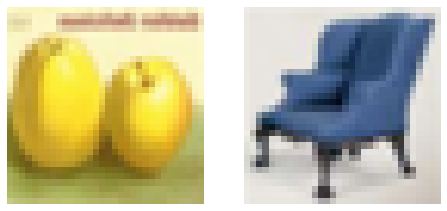

In [ ]:
oneshot1 = data1[0].permute(1, 2, 0).numpy()
oneshot2 = data2[10].permute(1, 2, 0).numpy()
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(oneshot1)
plt.axis("off")
plt.subplot(132)
plt.imshow(oneshot2)
plt.axis("off")
plt.show()

In [ ]:
class CNN(nn.Module):
  def __init__(self, Nway):
    super(CNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, 3), nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(256, 256, 3, stride=1), nn.ReLU(),
        nn.Conv2d(256, 256, 3, stride=1), nn.ReLU())
    self.classifier = nn.Sequential(
        nn.Linear(256, 128), nn.ReLU(), 
        nn.Linear(128, Nway))
  
  def forward(self, x):
    x = self.features(x)
    x = torch.mean(x, [2, 3])
    x = self.classifier(x)
    return x

  def parameterised(self, x, weights):
    x = F.relu(F.conv2d(x, weight=weights[0], bias=weights[1], stride=1))
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = F.relu(F.conv2d(x, weight=weights[2], bias=weights[3], stride=1, padding=1))
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = F.relu(F.conv2d(x, weight=weights[4], bias=weights[5], stride=1, padding=1))
    x = F.relu(F.conv2d(x, weight=weights[6], bias=weights[7], stride=1))
    x = F.relu(F.conv2d(x, weight=weights[8], bias=weights[9], stride=1))
    x = torch.mean(x, [2, 3])
    x = F.relu(F.linear(x, weights[10], weights[11]))
    x = F.linear(x, weights[12], weights[13])
    return x

class MAML:
  def __init__(self, num_tasks=300, Nway=5, alpha=1e-3, beta=1e-3, inner_steps=1, cls=None):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.num_tasks = num_tasks
    self.model = CNN(Nway).to(device)
    self.weights = list(self.model.parameters())
    self.beta = beta
    self.cifar100 = CIFAR100DataSet()
    self.task_collection = self.cifar100.task_set(num_tasks=self.num_tasks, cls=cls[:60], mode="train")
    self.meta_val_set = self.cifar100.task_set(num_tasks=30, cls=cls[60:], mode="val")
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=alpha, weight_decay=1e-4)
    self.inner_steps = inner_steps

  def inner_loop(self, dataloader):
    temp_weights = [w.clone() for w in self.weights]
    data = iter(dataloader).next()
    support, query, label = data[0].to(device), data[1].to(device), data[2].to(device)
    for i in range(self.inner_steps):
      outputs = self.model.parameterised(support, temp_weights)
      loss = self.criterion(outputs, label)
      grad = torch.autograd.grad(loss, temp_weights)
      temp_weights = [w - self.beta * g for w, g in zip(temp_weights, grad)]
    outputs = self.model.parameterised(query, temp_weights)
    inner_loss = self.criterion(outputs, label)
    return inner_loss

  def meta_train(self, num_epochs):
    loss_list = []
    acc = 0
    for epoch in range(num_epochs):
      self.optimizer.zero_grad()
      outer_loss = 0
      for i in range(self.num_tasks):
        outer_loss += self.inner_loop(self.task_collection[i])
      avg_loss = outer_loss / self.num_tasks
      avg_loss.backward()
      self.optimizer.step()
      ll = avg_loss.item()
      loss_list.append(ll)
      val_acc = self.meta_val()
      if epoch % 10 == 0:
        print("[%d] Train loss: %.3f, Validation accuracy: %.2f %%" %(epoch, ll, val_acc))
      if val_acc >= acc:
        acc = val_acc
        print("Saved the model - Validation accuracy: %.2f %%" %(val_acc))
        torch.save(self.model.state_dict(), f"{MODEL_SAVE_PATH}/cifar_maml.pt")
    return loss_list

  def meta_val(self):
    acc_list = []
    for i in range(len(self.meta_val_set)):
      cnn = copy.deepcopy(self.model)
      criterion = nn.CrossEntropyLoss()
      opt = optim.Adam(cnn.parameters(), lr=1e-2)
      num_epochs = 101
      testloader = self.meta_val_set[i]
      data1, data2, label = iter(testloader).next()
      cnn.train()
      for j in range(num_epochs):
        opt.zero_grad()
        outputs = cnn(data1.to(device))
        loss = criterion(outputs, label.to(device))
        loss.backward()
        opt.step()
      correct = 0
      total = 0
      with torch.no_grad():
        cnn.eval()
        outputs = cnn(data2.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label.to(device)).sum().item()
      acc_list.append(100 * correct / total)
    acc_info = np.array(acc_list)
    avg_acc = np.mean(acc_info)
    return avg_acc

In [ ]:
cls = np.random.choice(range(0, 100), 100, replace=False)
maml = MAML(num_tasks=300, Nway=5, cls=cls[:80])
loss = maml.meta_train(501)

Files already downloaded and verified
[0] Train loss: 1.610, Validation accuracy: 31.87 %
Saved the model - Validation accuracy: 31.87 %
Saved the model - Validation accuracy: 33.07 %
[10] Train loss: 1.357, Validation accuracy: 29.73 %


In [ ]:
def meta_test(task_collection, pretrained=None):
  acc_list = []
  for i in range(len(task_collection)):
    cnn = CNN(Nway).to(device)
    if pretrained == "meta":
      cnn.oad_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar_maml.pt"))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=1e-2)
    num_epochs = 101
    testloader = task_collection[i]
    data1, data2, label = iter(testloader).next()

    cnn.train()
    for j in range(num_epochs):
      optimizer.zero_grad()
      outputs = cnn(data1.to(device))
      loss = criterion(outputs, label.to(device))
      loss.backward()
      optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
      cnn.eval()
      outputs = cnn(data2.to(device))
      _, predicted = torch.max(outputs.data, 1)
      total += label.size(0)
      correct += (predicted == label.to(device)).sum().item()
    acc_list.append(100 * correct / total)
  acc_info = np.array(acc_list)
  print("Avg. Test accuracy: %.2f %% ± %.2f" % (np.mean(acc_info), 1.96*np.std(acc_info)/np.sqrt(len(acc_info))))

In [ ]:
meta_test_set = cifar100.task_set(num_tasks=100, cls=cls[80:])
meta_test(meta_test_set, "meta")

In [ ]:
meta_test(meta_test_set)

# Scientific Calculation

## Finite Difference Method

## Hidden Fluid Mechanics